In [2]:
from threading import Lock
import warnings
import matplotlib.pyplot as plt
import pyximport
from tqdm import tnrange, tqdm_notebook

warnings.filterwarnings('ignore')

import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), os.pardir))
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

pyximport.install(setup_args={"include_dirs": np.get_include()})
import XXZZham as XXZZham
from XXZZham import add_high_energies, rotate_to_00_base
import random
import adiabatic_sim as asim
import time

import multiprocessing
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(multiprocessing.cpu_count())))
import os
import LH_tools as LHT

%precision %.15f
PRECISION  = 2 ** -40

from IPython.display import display
import FD_tools as FDT
from numpy import angle,pi

In [18]:
def create_back_and_forward_props_return_EV(tlist, H_0, H_1):
    """

    Creates a back and forwared propagators
    :param tlist:
    :param H_0:
    :param H_1:
    :return:
    """
    EVs_forward = []
    n = len(H_0.dims[0])
    prop = tensor([qeye(2)] * n)
    tmax = max(tlist)
    last_time = 0
    for time in tlist:
        dt = abs(time - last_time)
        s = time / tmax
        Hs = H_0 * (1 - s) + H_1 * s
        EVs_forward.append(Hs.eigenstates(eigvals=2)[0])
        U = (-1j * Hs * dt).expm()
        prop = U * prop
        last_time = time
    last_time = 0
    backprop = tensor([qeye(2)] * n)
    for time in tlist[1:]:
        dt = abs(time - last_time)
        s = time / tmax
        Hs = H_0 * (s) + H_1 * (1 - s)
        U = (-1j * Hs * dt).expm()
        backprop = U * backprop
        last_time = time
    return backprop, prop,EVs_forward


In [126]:
def create_half_prop(tlist, H_0, H_1, epsilon =0.1):
    """

    Creates a back and forwared propagators
    :param tlist:
    :param H_0:
    :param H_1:
    :return:
    """
    EVs_forward = []
    n = len(H_0.dims[0])
    prop = tensor([qeye(2)] * n)
    tmax = max(tlist)
    last_time = 0
    for time in tlist:
        if time > tlist[-1]/2 - epsilon :
            return prop
        dt = abs(time - last_time)
        s = time / tmax
        Hs = H_0 * (1 - s) + H_1 * s
        EVs_forward.append(Hs.eigenstates(eigvals=2)[0])
        U = (-1j * Hs * dt).expm()
        prop = U * prop
        last_time = time


In [19]:
H0n, H1n, psi0n =  FDT.prepare_groverlike_system(15)
T12 = 4.84343434343
tlist = np.linspace(0,T12,150)
backprop, forwardprop,EVs_forward = create_back_and_forward_props_return_EV(tlist, H0n, H1n)

In [41]:

phase0 = sum([ev1 for ev1,ev2 in  (EVs_forward[len(EVs_forward)//2:])])
phase1 = sum([ev2 for ev1,ev2 in  (EVs_forward[len(EVs_forward)//2:])])

In [71]:
dt = tlist[1] - tlist[0]

In [106]:
psi = forwardprop * psi0n 
phi0_proj = LHT.proj_on(basis(2,0))
phi1_proj = LHT.proj_on(basis(2,1))
display(np.exp(1j*phase0*dt*2) * phi0_proj* psi)
display(np.angle((np.exp(1j*phase0*dt*2) * phi0_proj* psi)[0][0][0]))
display(np.exp(1j*phase1*dt*2) * phi1_proj* psi)
display(np.angle((np.exp(1j*phase1*dt*2)*phi1_proj* psi)[1][0][0]))

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 0.00679386+0.00634206j]
 [ 0.00000000+0.j        ]]

0.751017023498449

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 0.00000000+0.j        ]
 [ 0.33670231+0.94156528j]]

1.227368367842261

In [120]:
np.angle((np.exp(-1j*phase0*dt*2)*phi0_proj* psi)[0][0][0])

-1.670186314989131

In [121]:
np.angle((np.exp(-1j*(phase1+phase0)*dt)*phi1_proj* psi)[1][0][0])

1.407244422978723

In [124]:
pi/4

0.785398163397448

In [80]:
phase0*dt
phase1*dt

1.832669472473743

In [79]:
T12/8+ T12/4

1.816287878786250

In [146]:
half_prop12 = create_half_prop(tlist, H0n, H1n,0.01)

In [147]:
half_prop12*psi0n

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 0.00686103-0.00089976j]
 [ 0.82225480-0.56907747j]]

In [160]:
epsilon = 0.5
H_half_epsilon = H0n*(1/2+epsilon)+H1n*(1/2-0.1*epsilon)
ev_he0 ,ev_he1  = H_half_epsilon.eigenstates()[1]
(LHT.proj_on(ev_he0)+ LHT.proj_on(ev_he1)).data

array([ 1.+0.j,  1.+0.j])

In [161]:
H0n

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[  9.99969482e-01  -5.50909700e-03]
 [ -5.50909700e-03   3.05175781e-05]]

In [162]:
H1n

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.  0.]
 [ 0.  1.]]

# 9/8/17 finding phase in a simpler process

In [7]:
H0n, H1n, psi0n =  FDT.prepare_groverlike_system(15)


In [8]:
tlist = np.linspace(1,20,100)
slist= list(map(lambda t: t/20 ,tlist))

In [9]:
slist2 = slist[0:30]
slist2.extend(slist[30:0:-1])

In [10]:
backprop, forwardprop = FDT._create_back_and_forward_props_slist(slist2,tlist[0:60],H0n,H1n)

In [66]:
dangles = []
for repeat in range(15):
    psir = forwardprop**repeat * (-H0n.eigenstates()[1][0])
    anglea, angleb = angle(psir[0]), angle(psir[1])
    dangles.append((anglea-angleb)[0][0])
print(dangles)
for k in range(len(dangles)-1):
    print(dangles[k+1]- dangles[k])

[0.0, -0.83173341498370856, -1.7007334264888392, 1.4829142817626901, 0.16379601029245539, -0.67483400076079758, -1.5235565910168694, -3.6205152300825989, 0.333220196382923, -0.51817343125452187, -1.3552973181164634, -2.598251743043813, 0.51249376331292917, -0.36117607866544654, -1.1921933977372503]
-0.831733414984
-0.869000011505
3.18364770825
-1.31911827147
-0.838630011053
-0.848722590256
-2.09695863907
3.95373542647
-0.851393627637
-0.837123886862
-1.24295442493
3.11074550636
-0.873669841978
-0.831017319072


In [67]:
H0n, H1n, psi0n =  FDT.prepare_groverlike_system(10)
backprop, forwardprop = FDT._create_back_and_forward_props_slist(slist2,tlist[0:60],H0n,H1n)
dangles = []
for repeat in range(15):
    psir = forwardprop**repeat * (-H0n.eigenstates()[1][0])
    anglea, angleb = angle(psir[0]), angle(psir[1])
    dangles.append((anglea-angleb)[0][0])
print(dangles)
for k in range(len(dangles)-1):
    print(dangles[k+1]- dangles[k])

[0.0, -0.83173341498370856, -1.7007334264888392, 1.4829142817626901, 0.16379601029245539, -0.67483400076079758, -1.5235565910168694, -3.6205152300825989, 0.333220196382923, -0.51817343125452187, -1.3552973181164634, -2.598251743043813, 0.51249376331292917, -0.36117607866544654, -1.1921933977372503]
-0.831733414984
-0.869000011505
3.18364770825
-1.31911827147
-0.838630011053
-0.848722590256
-2.09695863907
3.95373542647
-0.851393627637
-0.837123886862
-1.24295442493
3.11074550636
-0.873669841978
-0.831017319072


In [59]:
forwardprop

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[-0.80901166+0.58737738j -0.01035873-0.0195103j ]
 [ 0.01475115-0.01644258j -0.64380539-0.76487036j]]

In [67]:
psir

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[-0.00718254+0.01229727j]
 [ 0.29142342+0.95648815j]]

In [65]:
abs((-H0n.eigenstates()[1][0])[1])

array([[ 0.99998482]])

## Check the spectrum ?

In [3]:
def _create_forward_prop_slist_show_spectrum(slist, tlist, H_0, H_1):
    """
    Creates a back and forwared propagators
    :param tlist:
    :param H_0:
    :param H_1:
    :return:
    """
    n = len(H_0.dims[0])
    prop = tensor([qeye(2)] * n)
    tmax = max(tlist)
    last_time = 0
    EVs = []
    for time, s_t in zip(tlist, slist):
        dt = abs(time - last_time)
        Hs = H_0 * (1 - s_t) + H_1 * s_t
        EVs.append(Hs.eigenenergies())
        U = (-1j * Hs * dt).expm()
        prop = U * prop
        last_time = time
    return prop, EVs
    

In [4]:
forwardprop,EVs = _create_forward_prop_slist_show_spectrum(slist2,tlist[0:60],H0n,H1n)
plt.plot(tlist[0:60],EVs)
plt.show()

NameError: name 'slist2' is not defined

In [24]:
slist

[0.050000000000000,
 0.059595959595960,
 0.069191919191919,
 0.078787878787879,
 0.088383838383838,
 0.097979797979798,
 0.107575757575758,
 0.117171717171717,
 0.126767676767677,
 0.136363636363636,
 0.145959595959596,
 0.155555555555556,
 0.165151515151515,
 0.174747474747475,
 0.184343434343434,
 0.193939393939394,
 0.203535353535354,
 0.213131313131313,
 0.222727272727273,
 0.232323232323232,
 0.241919191919192,
 0.251515151515152,
 0.261111111111111,
 0.270707070707071,
 0.280303030303030,
 0.289898989898990,
 0.299494949494949,
 0.309090909090909,
 0.318686868686869,
 0.328282828282828,
 0.337878787878788,
 0.347474747474747,
 0.357070707070707,
 0.366666666666667,
 0.376262626262626,
 0.385858585858586,
 0.395454545454545,
 0.405050505050505,
 0.414646464646465,
 0.424242424242424,
 0.433838383838384,
 0.443434343434343,
 0.453030303030303,
 0.462626262626263,
 0.472222222222222,
 0.481818181818182,
 0.491414141414141,
 0.501010101010101,
 0.510606060606061,
 0.520202020202020,


In [80]:
forwardprop * (-H0n.eigenstates()[1][0])

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[-0.03526580-0.00141387j]
 [-0.64304585-0.76501396j]]

In [76]:
angle(0.933-0.358j)

-0.366383547324220

In [83]:
angle(psir[0])


array([[-1.55851139]])

In [109]:
for m in range (15):
    psir = forwardprop**m * (-H0n.eigenstates()[1][0])
    print(angle(psir[0])[0][0] ,"\t\t", angle(psir[1])[0][0])


0.0 		 0.0
-3.10152218291 		 -2.26978876792
0.0426401343607 		 1.74337356085
0.955700746737 		 -0.527213535026
-2.63385088543 		 -2.79764689572
0.540857242748 		 1.21569124351
-2.57778306635 		 -1.05422647533
-0.662070238591 		 2.95844499149
1.02113710004 		 0.687916903657
-2.10019054045 		 -1.58201710919
1.07603566309 		 2.43133298121
-2.43733414885 		 0.160917594191
-1.59718511569 		 -2.109678879
1.54228804741 		 1.90346412608
-1.55851139493 		 -0.366317997195


In [130]:
sum(EVs)

array([ 11.63584293,  48.36415707])

In [220]:
dangles = []
for repeat in range(25):
    psir = forwardprop**repeat * (-H0n.eigenstates()[1][0])
    anglea, angleb = angle(psir[0]), angle(psir[1])
    dangles.append(((angleb-anglea)[0][0] % (2*pi)))
print(dangles)
for k in range(len(dangles)-1):
    print((dangles[k+1]- dangles[k] ))

[0.0, 0.83173341498370856, 1.7007334264888392, 4.8002710254168957, 6.1193892968871308, 0.67483400076079758, 1.5235565910168694, 3.6205152300825989, 5.9499651107966631, 0.51817343125452187, 1.3552973181164634, 2.598251743043813, 5.7706915438666568, 0.36117607866544654, 1.1921933977372503, 2.2006258359205262, 5.5724161824453269, 0.2032085023248561, 1.0322061868927643, 1.9519398012351805, 5.330945899515072, 0.043459311564800984, 0.8740992658098472, 1.7508179567819244, 4.9592581023177109]
0.831733414984
0.869000011505
3.09953759893
1.31911827147
-5.44455529613
0.848722590256
2.09695863907
2.32944988071
-5.43179167954
0.837123886862
1.24295442493
3.17243980082
-5.4095154652
0.831017319072
1.00843243818
3.37179034652
-5.36920768012
0.828997684568
0.919733614342
3.37900609828
-5.28748658795
0.830639954245
0.876718690972
3.20844014554


In [144]:
dangles = []
for repeat in range(25):
    psir = forwardprop**repeat * (-H0n.eigenstates()[1][0])
    anglea, angleb = angle(psir[0]), angle(psir[1])
    dangles.append((angleb-anglea)[0][0])
print(dangles)
for k in range(len(dangles)-1):
    print(dangles[k+1]- dangles[k])

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[-0.80795893-0.58918581j  0.00176882+0.00770186j]
 [-0.00662203+0.00431233j -0.99049632-0.13731203j]]

In [155]:
sum(EVs) * dt

array([ 2.23314157,  9.28200994])

In [168]:
phases = np.e**(1j*sum(EVs)[0] * dt) ,np.e**(sum(EVs)[1] * dt* 1j)

In [174]:
np.angle(phases)[1]-np.angle(phases)[0]

0.765683064574507

In [215]:
for m in range(10):
    phases = np.e**(m*1j*sum(EVs)[0] * dt) ,np.e**(m*sum(EVs)[1] * dt* 1j)
    print((np.angle(phases)[1]-np.angle(phases)[0])% (2*pi))

0.0
0.765683064575
1.53136612915
2.29704919372
3.0627322583
3.82841532287
4.59409838745
5.35978145202
6.1254645166
0.607962273991


In [212]:
for m in range(10):
    phases = np.e**(m*1j*sum(EVs)[0] * dt) ,np.e**(m*sum(EVs)[1] * dt* 1j)
    print(np.angle(phases)[0] % (2*pi))

0.0
2.2331415717
4.4662831434
0.416239407917
2.64938097962
4.88252255131
0.832478815833
3.06562038753
5.29876195923
1.24871822375


In [11]:
dangles = []
for repeat in range(25):
    psir = forwardprop**repeat * (-H0n.eigenstates()[1][0])
    anglea = angle(psir[0]) % (2*pi)
    print(anglea)

[[ 0.]]
[[ 3.17798551]]
[[ 0.03562775]]
[[ 1.02945477]]
[[ 3.65284052]]
[[ 0.53925127]]
[[ 3.7019523]]
[[ 5.85275445]]
[[ 1.0300598]]
[[ 4.18350247]]
[[ 1.07486255]]
[[ 3.92466626]]
[[ 4.70459955]]
[[ 1.54517427]]
[[ 4.72525368]]
[[ 1.47914827]]
[[ 2.12610588]]
[[ 5.19156736]]
[[ 2.08914581]]
[[ 5.19961264]]
[[ 5.91202325]]
[[ 2.55758747]]
[[ 5.73435472]]
[[ 2.5975577]]
[[ 3.7399747]]


In [18]:
forwardprop * -H0n.eigenstates()[1][0]

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[-0.00633118 -2.30511619e-04j]
 [-0.64628131 -7.63072953e-01j]]

In [25]:
-H1n.eigenstates()[1][0]

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 1.]
 [ 0.]]

# 10.8.17
So the computation must be more confusing because in this basis H0 is not (1;0) 
we can solve it in two ways : 

1 . Simpler - just evolve from H1

2 . Solve 2 equations in two variables 



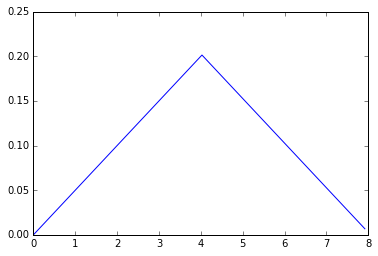

In [136]:
H0r = H1n
H1r = H0n
psi0n_r =   -H0r.eigenstates()[1][0] # = basis(2,0)
tlist = np.linspace(0,20,150)
slist1 =  tlist/20
tlist_ad = tlist[0:60]
slist_ad = np.concatenate([slist1[0:30], slist1[30:0:-1]])
plt.plot(tlist_ad,slist_ad)
plt.show()


In [137]:
forwardprop,EVs = _create_forward_prop_slist_show_spectrum(slist_ad, tlist_ad,H0r,H1r)

In [138]:
angleas = []
for repeat in range(25):
    psir = forwardprop**repeat * (-H0r.eigenstates()[1][0])
    anglea = (angle(psir[0]) % (2*pi))[0][0]
    angleas.append(anglea)
    print(anglea)

0.0
5.472441501
4.66169776526
3.85095417036
3.04021078671
2.22946768464
1.41872493448
0.607982606451
6.0804260779
5.26968480455
4.45894416354
3.64820422474
2.83746505787
2.02672673253
1.21598931814
0.405252883998
5.87770280636
5.06696853978
4.25623546012
3.44550363588
2.63477313531
1.82404402642
1.01331637696
0.202590254426
5.67505103321


In [139]:
np.diff(angleas) % (2*pi) 

array([ 5.4724415 ,  5.47244157,  5.47244171,  5.47244192,  5.47244221,
        5.47244256,  5.47244298,  5.47244347,  5.47244403,  5.47244467,
        5.47244537,  5.47244614,  5.47244698,  5.47244789,  5.47244887,
        5.47244992,  5.47245104,  5.47245223,  5.47245348,  5.47245481,
        5.4724562 ,  5.47245766,  5.47245918,  5.47246078])

In [143]:
dt = tlist_ad[1] -  tlist_ad[0]
theoretical_phase_integ = (-np.max(tlist_ad) * np.max(EVs,axis=0)[0] / 2)  % (2*pi)
theoretical_phase_sum = (-sum(EVs)[0] * dt)  % (2*pi)
theoretical_phase, theoretical_phase_sum  % (2*pi)

(6.012938223098673, 5.472440552055469)

# GREAT !  at last something that works!!!
The computed phase is the same as the one gained by evolution, I guess the sum should converge to the integral with more precision ... let's check it

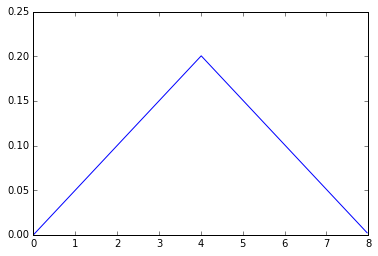

In [148]:
more_precision = 3
H0r = H1n
H1r = H0n
psi0n_r =   -H0r.eigenstates()[1][0] # = basis(2,0)
tlist = np.linspace(0,20,150  * more_precision)
slist1 =  tlist/20
tlist_ad = tlist[0:60*more_precision]
slist_ad = np.concatenate([slist1[0:30*more_precision], slist1[30*more_precision:0:-1]])
plt.plot(tlist_ad,slist_ad)
plt.show()


In [149]:
forwardprop, EVs = _create_forward_prop_slist_show_spectrum(
    slist_ad, tlist_ad, H0r, H1r)
dt = tlist_ad[1] - tlist_ad[0]
theoretical_phase_integ = (-np.max(tlist_ad) * np.max(EVs, axis=0)[0] / 2) % (2 * pi)
theoretical_phase_sum = (-sum(EVs)[0] * dt) % (2 * pi)
theoretical_phase_integ, theoretical_phase_sum

(5.484114628981880, 5.479647101832634)

# so even with steps = 150 we get pretty good precision, the result from before where  wrong due to a programing error

In [150]:
# now what about the phase in the total process ? 

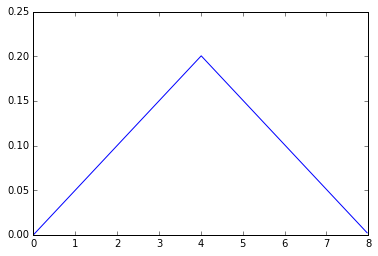

In [190]:
more_precision = 15
H0r = H1n
H1r = H0n
psi0n_r =   -H0r.eigenstates()[1][0] # = basis(2,0)
tlist = np.linspace(0,20,150  * more_precision)
slist1 =  tlist/20
plt.plot(tlist_ad,slist_ad)
plt.show()


In [193]:
forwardprop, EVs = _create_forward_prop_slist_show_spectrum(
    slist1, tlist, H0n, H1n)
dt = tlist[1] - tlist[0]
theoretical_phase_triangle = (-np.max(tlist) * np.max(EVs, axis=0)[0] / 2) 
theoretical_phase_sum = (-sum(EVs)[0] * dt) 
theoretical_phase_triangle, theoretical_phase_sum

(-4.972364590860661, -4.999105641504801)

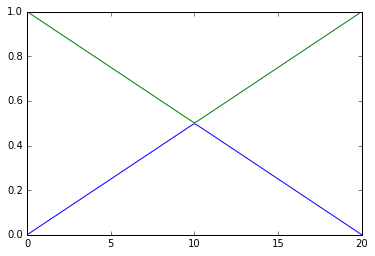

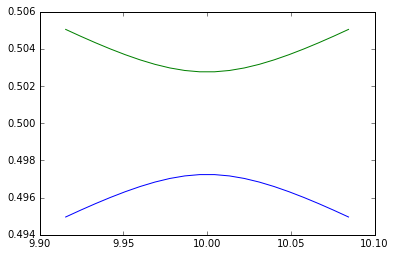

In [194]:

plt.plot(tlist,EVs)
plt.show()
middle = [len(tlist)//2-10,len(tlist)//2+10]
plt.plot(tlist[middle[0]:middle[1]],EVs[middle[0]:middle[1]])
plt.show()


In [195]:
# decrease n ? 

-5.0 -4.9991056415


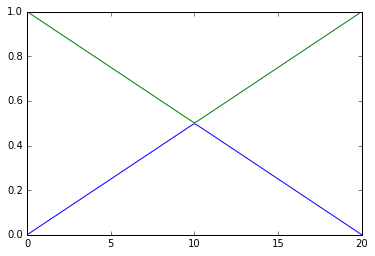

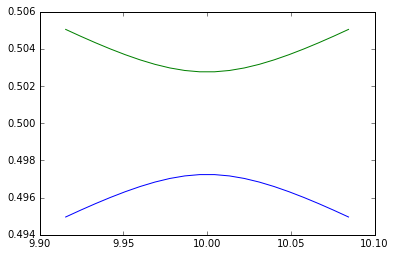

In [202]:
H0n, H1n, psi0n =  FDT.prepare_groverlike_system(15)
more_precision = 15
H0r = H1n
H1r = H0n
psi0n_r =   -H0r.eigenstates()[1][0] # = basis(2,0)
tlist = np.linspace(0,20,150  * more_precision)
slist1 =  tlist/20
forwardprop, EVs = _create_forward_prop_slist_show_spectrum(
    slist1, tlist, H0n, H1n)
dt = tlist[1] - tlist[0]
theoretical_phase_triangle = (-np.max(tlist) *1/2/ 2) 
theoretical_phase_sum = (-sum(EVs)[0] * dt) 
print(theoretical_phase_triangle, theoretical_phase_sum)

plt.plot(tlist,EVs)
plt.show()
middle = [len(tlist)//2-10,len(tlist)//2+10]
plt.plot(tlist[middle[0]:middle[1]],EVs[middle[0]:middle[1]])
plt.show()


In [204]:
# so it seems like the phase is actually close to the triangle, 
# however maybe we should take a better approximation, bounding the integral between interesting points?